In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import bernoulli
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold
from sklearn.svm import SVC

In [2]:
np.random.seed(1457065)
n_gen = 50
n_samples = 4*n_gen
data_red_1 = np.random.multivariate_normal(mean=np.array([0.5,0.5]),
                                             cov=np.array(([2,-0.5],[-0.5,2])),
                                             size=n_gen)
data_red_2 = np.random.uniform(low=0.5, high=2, size=(n_gen,2))

data_blue_1 = np.random.multivariate_normal(mean=np.array([-1,-1]),
                                            cov=np.eye(2),
                                            size=n_gen)
data_blue_2 = np.random.uniform(low=-1, high=0., size=(n_gen,2))

data_red = np.vstack((data_red_1,data_red_2))
labels_red = (np.ones(2*n_gen)*-1).reshape(2*n_gen,1)
data_red = np.hstack((data_red,labels_red))

data_blue = np.vstack((data_blue_1, data_blue_2))
labels_blue = (np.ones(2*n_gen)).reshape(2*n_gen,1)
data_blue = np.hstack((data_blue,labels_blue))

whole_data = np.vstack((data_blue, data_red))

In [3]:
data_df = pd.DataFrame(whole_data)
data_df.columns = ['x1','x2','class']
data_df['label'] = np.ones(n_samples)*(-1)
for i in range(n_samples):
    random = bernoulli.rvs(p=3/4)
    if data_df.loc[i,'class'] == 1 and random == 0:
        data_df.loc[i,'label'] = 1
n_positives = data_df[data_df['label'] == 1].shape[0]

In [4]:
positive_instances = data_df[data_df['label'] == 1]
unlabelled_set = data_df[data_df['label'] == -1]
df_for_results = data_df.copy()
t = 15
for i in range(t):
    u_t = unlabelled_set.sample(n=n_positives)
    train_set = pd.concat([positive_instances,u_t])
    indexes_to_drop = list(train_set.index)
    f_t = SVC(decision_function_shape='ovr').fit(X=train_set.to_numpy()[:,:-2],y=train_set['label'].to_numpy())
    to_be_pred = data_df.drop(labels=indexes_to_drop,axis=0)
    predictions = f_t.decision_function(X=to_be_pred.to_numpy()[:,:-2])
    to_be_pred[f'score_{i}'] = predictions
    df_pred = pd.DataFrame(to_be_pred[f'score_{i}'])
    df_for_results = df_for_results.merge(df_pred, how='left', left_index=True,right_index=True)

In [5]:
indexes_positive = list(df_for_results[df_for_results['label'] == 1].index)
last_df = df_for_results.drop(labels=indexes_positive,axis=0).copy()
last_df = last_df.drop(['x1','x2','label'],axis=1)
classes_for_comp = last_df['class'].copy().to_numpy()
last_df = last_df.drop(['class'], axis=1)
average = last_df.mean(axis=1).to_numpy()
positive = 0
true_positive = 0
for i in range(average.shape[0]):
    average[i] = np.sign(average[i])
for i in range(average.shape[0]):
    if average[i] == 1:
        positive += 1
        if classes_for_comp[i] == 1:
            true_positive += 1



precision = true_positive/(positive)
recall = true_positive/((n_gen*2)) #accurately positive predicted instances/#the total number of positives
f_1_score = (2*recall*precision)/(precision+recall)
weird_estimation_score = (recall**2)/(positive/n_samples)
print('the precision on the training data is : ', precision, '\n',
     'the recall on the training data is : ', recall, '\n',
     'the f_1 score on the training data is : ', f_1_score, '\n',
     'the strange estimator is given by : ', weird_estimation_score)

the precision on the training data is :  0.8636363636363636 
 the recall on the training data is :  0.76 
 the f_1 score on the training data is :  0.8085106382978724 
 the strange estimator is given by :  1.3127272727272727


In [6]:
Z = np.zeros((500**2,1))
Z = pd.DataFrame(Z)
Z.columns = ['init']
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
for i in range(t):
    u_t_z = unlabelled_set.sample(n=n_positives)
    train_set_z = pd.concat([positive_instances,u_t_z])
    indexes_to_drop = list(train_set_z.index)
    f_t = SVC(decision_function_shape='ovr').fit(X=train_set_z.to_numpy()[:,:-2],y=train_set_z['label'].to_numpy())
    to_be_pred = data_df.drop(labels=indexes_to_drop,axis=0)
    predictions_z = f_t.decision_function(X=np.c_[xx.ravel(), yy.ravel()])
    Z[f'score_{i}'] = predictions_z

In [7]:
Z = Z.drop(['init'],axis=1)
Z = Z.mean(axis=1)
Z = Z.to_numpy()
Z = Z.reshape(xx.shape)

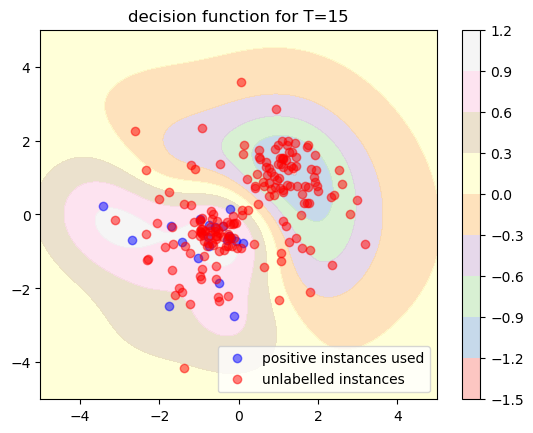

In [8]:
plt.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.Pastel1)
plt.plot(positive_instances.to_numpy()[:,0], positive_instances.to_numpy()[:,1], 'bo', alpha=0.5,label='positive instances used')
plt.plot(unlabelled_set.to_numpy()[:,0], unlabelled_set.to_numpy()[:,1], 'ro', alpha=0.5, label='unlabelled instances')
plt.title(f'decision function for T={t}')
plt.legend()
plt.colorbar()
plt.savefig('decision_function_bagging_svm_not_sep.png')

In [9]:
binary_z = Z.copy()
for i in range(Z.shape[0]):
    for k in range(Z.shape[1]):
        binary_z[i,k] = np.sign(binary_z[i,k])

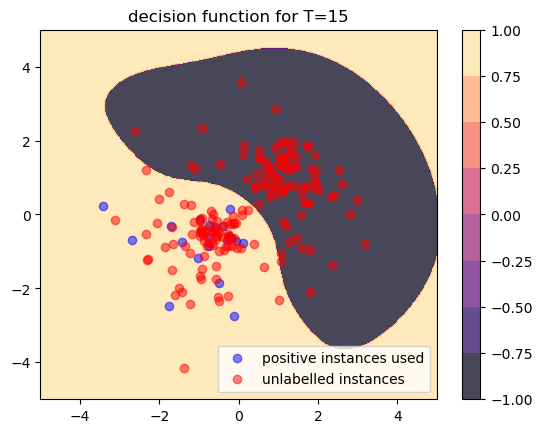

In [10]:
plt.contourf(xx, yy, binary_z, alpha=0.75, cmap=plt.cm.magma)
plt.plot(positive_instances.to_numpy()[:,0], positive_instances.to_numpy()[:,1], 'bo', alpha=0.5,label='positive instances used')
plt.plot(unlabelled_set.to_numpy()[:,0], unlabelled_set.to_numpy()[:,1], 'ro', alpha=0.5, label='unlabelled instances')
plt.title(f'decision function for T={t}')
plt.legend()
plt.colorbar()

In [11]:
n_gen_test = 10
n_samples_test = 4*n_gen_test
data_n_test_1 = np.random.multivariate_normal(mean=np.array([0.5,0.5]),
                                             cov=np.array(([2,-0.5],[-0.5,2])),
                                             size=n_gen_test)
data_n_test_2 = np.random.uniform(low=0.5, high=2., size=(n_gen_test,2))

data_p_test_1 = np.random.multivariate_normal(mean=np.array([-1,-1]),
                                            cov=np.eye(2),
                                            size=n_gen_test)
data_p_test_2 = np.random.uniform(low=-1, high=0., size=(n_gen_test,2))

data_test = np.vstack((data_n_test_1,data_n_test_2,data_p_test_1,data_p_test_2))
data_test = np.hstack((data_test,np.hstack((np.ones(n_gen_test*2)*(-1),np.ones(n_gen_test*2))).reshape(n_samples_test,1)))

In [12]:
test_results = np.zeros((n_samples_test,1))
test_results = pd.DataFrame(test_results)
test_results.columns = ['init']
for i in range(t):
    u_t_t = unlabelled_set.sample(n=n_positives)
    train_set_t = pd.concat([positive_instances,u_t_t])
    indexes_to_drop = list(train_set.index)
    f_t = SVC(decision_function_shape='ovr').fit(X=train_set_t.to_numpy()[:,:-2],y=train_set_t['label'].to_numpy())
    predictions_t = f_t.decision_function(X=data_test[:,:-1])
    test_results[f'score_{i}'] = predictions_t

In [13]:
test_results = test_results.drop(['init'],axis=1)
test_results = test_results.mean(axis=1)

In [14]:
test_results = test_results.to_numpy()
for i in range(n_samples_test):
    test_results[i] = np.sign(test_results[i])
    
positives = 0
true_positives = 0
for i in range(n_samples_test):
    if test_results[i] == 1:
        positives += 1
        if data_test[i,2] == 1:
            true_positives += 1

precision_test = true_positives/positives
recall_test = true_positives/(n_gen_test*2)
f_1_test = (2*precision_test*recall_test)/(precision_test+recall_test)
weird_test = (recall_test**2)/(positives/n_samples_test)

print('the precision on the test set is : ', precision_test, '\n', 
      'the recall on the test set is : ', recall_test, '\n', 
      'the f_1 score on the test set is : ', f_1_test, '\n', 
      'the weird metric on the test set is : ', weird_test)

the precision on the test set is :  0.8636363636363636 
 the recall on the test set is :  0.95 
 the f_1 score on the test set is :  0.9047619047619048 
 the weird metric on the test set is :  1.6409090909090907
